# Figure generation notebook

Here we generate figures/plots to be used in the report. In order to do so, we train the GPs as we do in the main notebook, Gaussian_Process, and then generate the desired plots using them and the other stuff imported in the "Run setup" cell

In [5]:
# Make the cells wider in the browser window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import numpy as np
from numba import jit
from time import time
from sklearn.gaussian_process import GaussianProcessRegressor, kernels

matplotlib.rc("figure", figsize=(16,3))
matplotlib.rc("lines", linewidth=2)
# matplotlib.rc("font", serif='Computer Modern Roman')
# matplotlib.rc("title", fontsize=18)

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Run setup

In [2]:
# Run a setup script which defines some functions and constants for the MPC problems and what not
from mpc_util_functions import *

***

# Train the GP models

In [6]:
# data_dim = 20
data_dim = intervals_per_day

# First, we need to create the X matrix of training data which corresponds to the past 96 intervals of each point
N = train.shape[0]
# subtract one_day because we don't have previous day data for first day and a second day because 
# we can't predict into data we don't have at the end
X = np.zeros((N-2*data_dim, data_dim)) 
y = np.zeros((X.shape[0], data_dim))
# y = train.values[data_dim:]

for i in range(X.shape[0]):
    X[i,:] = train.values[i:(i+data_dim)]
    y[i,:] = train.values[(i+data_dim):(i+2*data_dim)]
    
# Limit the number of samples cause there's not enough memory to train on the whole training set
train_size = 2000
X = X[-train_size:, :]
y = y[-train_size:, :]


# Also create the test set by doing basically all the same stuff:
N_test = test.shape[0]
# we don't need to subtract cause we have the training data, but easier to just ignore that single bit of data
X_test = np.zeros((N_test-2*data_dim, data_dim)) 
y_test = np.zeros((X_test.shape[0], data_dim))

for i in range(X_test.shape[0]):
    X_test[i,:] = test.values[i:(i+data_dim)]
    y_test[i,:] = test.values[(i+data_dim):(i+2*data_dim)]
    
# Limit the number of samples cause there's not enough memory to train on the whole training set
test_size = 2000
X_test = X_test[:test_size, :]
y_test = y_test[:test_size, :]

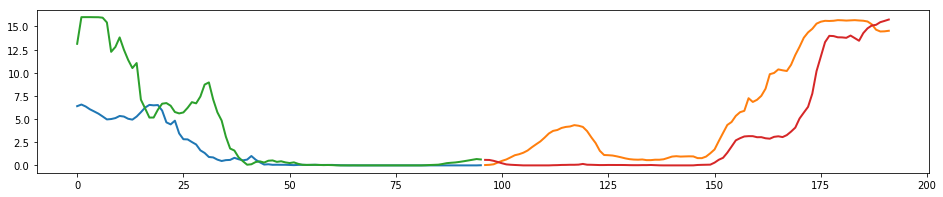

In [7]:
# Make sure the predicted points really are the points that come right after the points used as input for pred
test_pt = 22
plt.plot(np.arange(data_dim), X[test_pt,:])
plt.plot(range(data_dim, 2*data_dim), y[test_pt, :]);

plt.plot(np.arange(data_dim), X_test[test_pt,:])
plt.plot(range(data_dim, 2*data_dim), y_test[test_pt, :]);

<a id="matern_vector"></a>
## Matern Kernel

**Fit scores for certain parameters:** 


In [8]:
# Try making a kernel, copy one from one of the examples from sklearn
train_data_var = np.var(train)
kern = train_data_var * (2/3) * kernels.Matern(length_scale=23, length_scale_bounds=(23, 24))

tic = time()
# tried n_optimizer = 4, took long time
vec_matern_gp = GaussianProcessRegressor(kernel=kern, normalize_y=True, copy_X_train=False).fit(X,y) 
print("Time taken to train GP on %d samples of dimension %d: %.1f secs" % (train_size, data_dim, (time() - tic)))

fit_score = vec_matern_gp.score(X_test, y_test)
print("Fit score on test set: %.4f" % fit_score)

log_lik = vec_matern_gp.log_marginal_likelihood_value_
print("Log-likelihood of kernel theta: %.4f" % log_lik )

print("Kernel params to see what length scale it used")
vec_matern_gp.kernel_.get_params

Time taken to train GP on 2000 samples of dimension 96: 101.7 secs
Fit score on test set: -0.2217
Log-likelihood of kernel theta: -353165.3760
Kernel params to see what length scale it used


<bound method KernelOperator.get_params of 4.31**2 * Matern(length_scale=23.1, nu=1.5)>

In [26]:
# Now, get some samples then subtract out the mean to see how the samples represent potential residuals
# Then, estimate the covariance of those residuals
# For reference, the covariance matrix sigma_residual_errors was estimated based off of 69889 samples

num_samps = 10   # number of samples to draw at each query point

tic = time()
y_mean = vec_matern_gp.predict(X_test)
samps = vec_matern_gp.sample_y(X_test, num_samps)
print("Time taken to predict %i points and sample %i times at each: %.1f sec" % (X_test.shape[0], num_samps, time()-tic))

# Now, subtract the mean from each sample to get the residuals, from the perspective of the GP
resids = (samps - y_mean[:, :, np.newaxis])

# Reshape resids so that it's a matrix, not a tensor
dummy = np.zeros((resids.shape[0]*resids.shape[2], resids.shape[1]))
counter = 0
for i in range(resids.shape[0]):
    for j in range(resids.shape[2]):
        dummy[counter, :] = resids[i, :, j]
        counter+=1
        
matern_samp_resids = dummy
del dummy
del resids

# Now, estimate the covariance matrix based off of these samples
tic = time()
matern_samp_cov = np.cov(matern_samp_resids.T)
print("Time taken to estimate covariance matrix using %i samples: %.1f" % (matern_samp_resids.shape[0], time() - tic))

Time taken to predict 2000 points and sample 10 times at each: 311.5 sec
Time taken to estimate covariance matrix using 2000 samples: 0.0


In [24]:
# Also, actually predict the training set and get the residuals of the prediction, not just samples

y_mean = vec_matern_gp.predict(X)

matern_resids = X - y_mean

matern_cov = np.cov(matern_resids.T)


<a id="rbf_vector"></a>
## RBF Kernel

**Fit scores for certain parameters:** 


In [27]:
# Try making a kernel, copy one from one of the examples from sklearn
train_data_var = np.var(train)
kern = train_data_var * (2/3) * kernels.RBF(length_scale=12, length_scale_bounds=(12, 13))

tic = time()
# tried n_optimizer = 4, took long time
vec_rbf_gp = GaussianProcessRegressor(kernel=kern, normalize_y=True, copy_X_train=False).fit(X,y) 
print("Time taken to train GP on %d samples of dimension %d: %.1f secs" % (train_size, data_dim, (time() - tic)))

fit_score = vec_rbf_gp.score(X_test, y_test)
print("Fit score on test set: %.4f" % fit_score)

log_lik = vec_rbf_gp.log_marginal_likelihood_value_
print("Log-likelihood of kernel theta: %.4f" % log_lik )

print("Kernel params to see what length scale it used")
vec_rbf_gp.kernel_.get_params

Time taken to train GP on 2000 samples of dimension 96: 80.2 secs
Fit score on test set: -0.1684
Log-likelihood of kernel theta: -393435.1346
Kernel params to see what length scale it used


<bound method KernelOperator.get_params of 4.67**2 * RBF(length_scale=12.2)>

In [29]:
# Now, get some samples then subtract out the mean to see how the samples represent potential residuals
# Then, estimate the covariance of those residuals
# For reference, the covariance matrix sigma_residual_errors was estimated based off of 69889 samples

num_samps = 10   # number of samples to draw at each query point

tic = time()
y_mean = vec_rbf_gp.predict(X_test)
samps = vec_rbf_gp.sample_y(X_test, num_samps)
print("Time taken to predict %i points and sample %i times at each: %.1f sec" % (X_test.shape[0], num_samps, time()-tic))

# Now, subtract the mean from each sample to get the residuals, from the perspective of the GP
resids = (samps - y_mean[:, :, np.newaxis])

# Reshape resids so that it's a matrix, not a tensor
dummy = np.zeros((resids.shape[0]*resids.shape[2], resids.shape[1]))
counter = 0
for i in range(resids.shape[0]):
    for j in range(resids.shape[2]):
        dummy[counter, :] = resids[i, :, j]
        counter+=1
        
rbf_samp_resids = dummy
del dummy
del resids

# Now, estimate the covariance matrix based off of these samples
tic = time()
rbf_samp_cov = np.cov(rbf_samp_resids.T)
print("Time taken to estimate covariance matrix using %i samples: %.1f" % (rbf_samp_resids.shape[0], time() - tic))

Time taken to estimate covariance matrix using 20000 samples: 0.0


In [30]:
# Also, actually predict the training set and get the residuals of the prediction, not just samples

y_mean = vec_rbf_gp.predict(X)

rbf_resids = X - y_mean

rbf_cov = np.cov(rbf_resids.T)


***

# Covariance matrix images

### Diagonal Covariance matrix

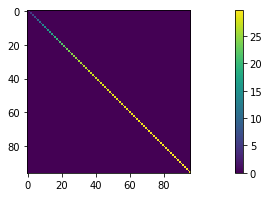

In [80]:
plt.imshow(np.diag(np.diag(sigma_residual_errors)));
plt.colorbar();

### Original Covariance matrix

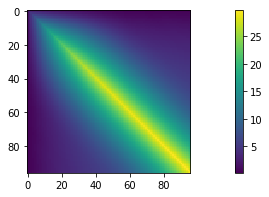

In [79]:
plt.imshow(sigma_residual_errors);
plt.colorbar();

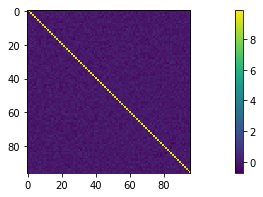

In [31]:
plt.imshow(matern_samp_cov)
plt.colorbar();

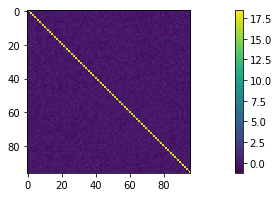

In [32]:
plt.imshow(rbf_samp_cov)
plt.colorbar();

### Covariance matrix estimated from samples of Matern GP

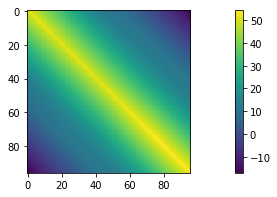

In [33]:
# Matern
plt.imshow(matern_cov);
plt.colorbar();

### Covariance matrix estimated from samples of RBF GP

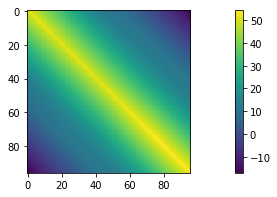

In [34]:
# rbf
plt.imshow(rbf_cov);
plt.colorbar();

***

# Residual Images

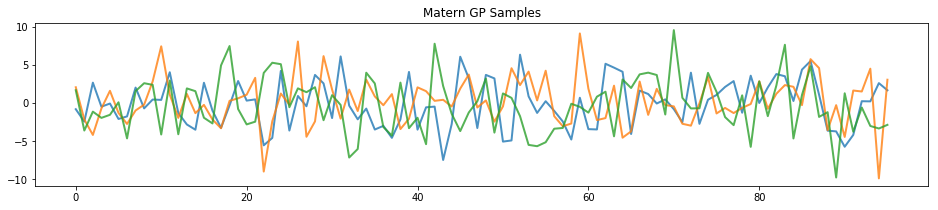

In [35]:
num_plot = 3

for i in range(num_plot):
    plt.plot(matern_samp_resids[i, :], alpha=0.8)
plt.title("Matern GP Samples");

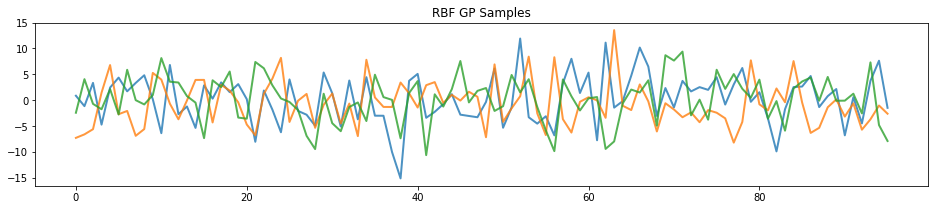

In [36]:
num_plot = 3
for i in range(num_plot):
    plt.plot(rbf_samp_resids[i, :], alpha=0.8)
plt.title("RBF GP Samples");

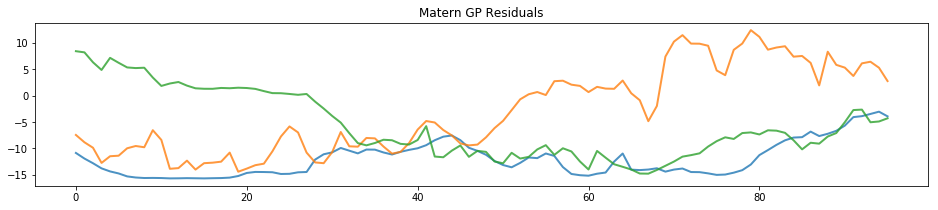

In [41]:
num_plot = 3
rand_inds = np.random.randint(0, high=matern_resids.shape[0], size=num_plot)
for i in range(num_plot):
    plt.plot(matern_resids[rand_inds[i], :], alpha=0.8)
plt.title("Matern GP Residuals");

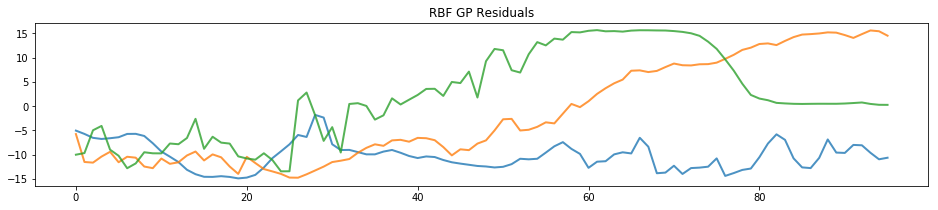

In [40]:
num_plot = 3
rand_inds = np.random.randint(0, high=rbf_resids.shape[0], size=num_plot)
for i in range(num_plot):
    plt.plot(rbf_resids[rand_inds[i], :], alpha=0.8)
plt.title("RBF GP Residuals");

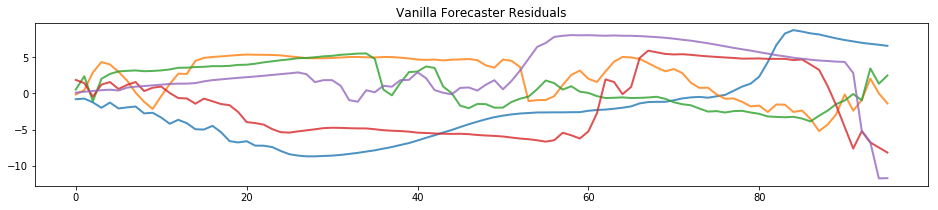

In [104]:
num_plot = 5
rand_inds = np.random.randint(0, high=train_residuals.shape[0], size=num_plot)
for i in range(num_plot):
    plt.plot(train_residuals[rand_inds[i],:], alpha=0.8)
plt.title("Vanilla Forecaster Residuals");

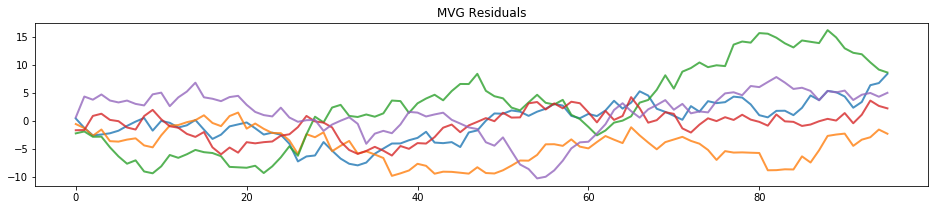

In [103]:
num_plot = 5
mvg_samps = np.random.multivariate_normal(np.zeros(96), sigma_residual_errors, num_plot)
for i in range(num_plot):
    plt.plot(mvg_samps[i,:], alpha=0.8)
plt.title("MVG Residuals");